To answer questions that agencies may care:
1. What's the best time to do road construction work such that construction-related delay can be minimized?
2. How would improving unplanned event reporting improve travel-time reliability?

Insights we hope to obtain:
1. Time-of-day patterns dominate short-term travel time — meaning proactive congestion management (e.g., signal timing, ramp metering) may be more valuable than reactive incident data.
2. Unplanned event underreporting limits predictive power — improving incident data collection could yield measurable gains in travel-time reliability.
3. Planned work zones can be optimized — data-driven scheduling could reduce construction-related delay and improve traveler satisfaction.

## Workflow
1. train `no_evt` regression model with no evt features and no evt data. This will be a baseline model that predicts "what is likely to be the travel time if there's no planned or unplanned events?"
2. train `plnd_evt` with planned evt data and planned evt feature
3. diff= `plnd_evt.pred`-`no_evt.pred` is model's estimated event impact (note: only as good as model fit; not guaranteed causal)
4. residual = `data`-`plnd_evt.pred` captures the remaining unexplaiend delays due to unplanned events and other unmodeled factors (e.g., weather, #lanes)
5. analysis: average diff by hour of day

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import i10_models as m

In [2]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))
print(X_full.columns)

X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 31)
Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp',
       'onramp', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'evt_total',
       'speed_ratio', 'lag1', 'lag2', 'lag3', 'tt_per_mile',
       'lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile',
       'log_tt_per_mile', 'log_lag1_tt_per_mile', 'log_lag2_tt_per_mile',
       'log_lag3_tt_per_mile'],
      dtype='object')


In [96]:
# 2. split train/test based on time (80% train, 20% test)
time_bins = X_full.index.get_level_values('time_bin').unique().sort_values()

split_idx = int(len(time_bins) * 0.8)
train_times = time_bins[:split_idx]
test_times  = time_bins[split_idx:]

df_train = X_full.loc[pd.IndexSlice[:, train_times], :]
df_test  = X_full.loc[pd.IndexSlice[:, test_times], :]

# 3. balance the training data
any_event = df_train['evt_total'] > 0
df_no_events = df_train[~any_event].sample(frac=0.04, random_state=42) # train lr_no_evt
df_plnd_events    = df_train[df_train['evt_cat_planned'] > 0] 

df_balanced = pd.concat([df_no_events, df_plnd_events]) # train lr_plnd_evt
print(f"{len(df_plnd_events)}/{len(df_balanced)}={100 * len(df_plnd_events) / len(df_balanced):.2f}% training data has planned events, compared to {len(df_plnd_events)}/{len(df_train)}={100 * len(df_plnd_events) / len(df_train):.2f}% in the original training data")
print(f"{len(df_plnd_events)}/{len(df_no_events)}={100 * len(df_plnd_events) / len(df_no_events):.2f}% planned events : no events")

# 4. shuffle the training data
df_no_events = df_no_events.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

477/4245=11.24% training data has planned events, compared to 477/94950=0.50% in the original training data
477/3768=12.66% planned events : no events


In [97]:
# ==================
TARGET_COL = 'tt_per_mile'
DIR = 'WB' # 'WB' or 'EB'
# ===================

time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_planned', 'evt_cat_unplanned']
log_lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
lag_features = ['lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + log_lag_features + tmc_features

tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}
# Unique TMCs (nodes) and timestamps
time_index = sorted(X_full.index.get_level_values('time_bin').unique())
tmc_order = tmc_order_dict[DIR]
N = len(tmc_order)
T = len(time_index)

In [98]:
# Re-train LR and Tree models
no_evt_features = time_features + log_lag_features + tmc_features
plnd_evt_features = time_features + ['evt_cat_planned'] + log_lag_features + tmc_features

models = {
    'no_evt': m.make_model(m.make_preprocessor(no_evt_features, scale=False), m.make_xgb()),
    'plnd_evt': m.make_model(m.make_preprocessor(plnd_evt_features, scale=False), m.make_xgb())
}

# train each model
X_train_plnd_evt = df_balanced[plnd_evt_features]
y_train_plnd_evt = df_balanced[TARGET_COL]
X_test_plnd_evt = df_test[plnd_evt_features]
y_test_plnd_evt = df_test[TARGET_COL]

X_train_no_evt = df_no_events[no_evt_features]
y_train_no_evt = df_no_events[TARGET_COL]
X_test_no_evt = df_test[no_evt_features]
y_test_no_evt = df_test[TARGET_COL]

metrics_no_evt = m.evaluate_model('no_evt', models['no_evt'], X_train_no_evt, y_train_no_evt, X_test_no_evt, y_test_no_evt, cv=False)
metrics_plnd_evt = m.evaluate_model('plnd_evt', models['plnd_evt'], X_train_plnd_evt, y_train_plnd_evt, X_test_plnd_evt, y_test_plnd_evt, cv=False)


In [33]:
# Re-train GCN-LSTM model
SEQ_LEN = 24

no_evt_features = time_features + lag_features + tmc_features
plnd_evt_features = time_features + ['evt_cat_planned'] + lag_features + tmc_features
edge_index_dict, node_id_dict = m.build_highway_graphs(tmc_order_dict)
# models = {
#     'no_evt': None,
#     'plnd_evt': None
# }

# Training no_evt model
tensors_dict = m.dataframe_to_tensors_by_direction(X_full, no_evt_features, TARGET_COL, tmc_order_dict)
data_dict = m.build_pyg_data_dict(tensors_dict, edge_index_dict)
data = data_dict[DIR]
edge_index = edge_index_dict[DIR]
in_features = data.X.shape[-1]
models['no_evt'] = m.GCN_LSTM(in_features=in_features, gcn_hidden=64, lstm_hidden=128, out_features=1, edge_index=edge_index)
models['no_evt'] = m.train_gcn_lstm(models['no_evt'], data, seq_len=SEQ_LEN, epochs=100, batch_size=128, lr=1e-3, device='default')
models['no_evt'].preds = m.predict_sequence(models['no_evt'], data, seq_len=SEQ_LEN, device='default').squeeze(-1)  # [T_eval, N]

# Training plnd_evt model
# tensors_dict = m.dataframe_to_tensors_by_direction(X_full, plnd_evt_features, TARGET_COL, tmc_order_dict)
# data_dict = m.build_pyg_data_dict(tensors_dict, edge_index_dict)
# data = data_dict[DIR]
# edge_index = edge_index_dict[DIR]
# in_features = data.X.shape[-1]
# models['plnd_evt'] = m.GCN_LSTM(in_features=in_features, gcn_hidden=64, lstm_hidden=128, out_features=1, edge_index=edge_index)
# models['plnd_evt'] = m.train_gcn_lstm(models['plnd_evt'], data, seq_len=SEQ_LEN, epochs=100, batch_size=128, lr=1e-3, device='default')
# models['plnd_evt'].preds = m.predict_sequence(models['plnd_evt'], data, seq_len=SEQ_LEN, device='default').squeeze(-1)  # [T_eval, N]

Training samples: 2112, Validation samples: 238
Epoch 1/100 | Train 2668.3899 | Val 2810.3654
Epoch 2/100 | Train 2159.5283 | Val 2253.7329
Epoch 3/100 | Train 1628.8160 | Val 1717.0701
Epoch 4/100 | Train 1129.6286 | Val 1216.5529
Epoch 5/100 | Train 681.0714 | Val 778.7957
Epoch 6/100 | Train 318.5232 | Val 451.1953
Epoch 7/100 | Train 98.4924 | Val 294.3945
Epoch 8/100 | Train 50.7861 | Val 294.3279
Epoch 9/100 | Train 49.8297 | Val 290.3429
Epoch 10/100 | Train 49.1652 | Val 292.3465
Epoch 11/100 | Train 48.9080 | Val 291.2656
Epoch 12/100 | Train 46.4591 | Val 271.3669
Epoch 13/100 | Train 43.6782 | Val 260.7049
Epoch 14/100 | Train 42.3226 | Val 252.9001
Epoch 15/100 | Train 41.3482 | Val 251.2395
Epoch 16/100 | Train 40.4561 | Val 253.8849
Epoch 17/100 | Train 40.8207 | Val 252.0035
Epoch 18/100 | Train 39.8228 | Val 258.5538
Epoch 19/100 | Train 39.5202 | Val 252.2955
Epoch 20/100 | Train 39.2474 | Val 258.3560
Epoch 21/100 | Train 38.6225 | Val 249.5688
Epoch 22/100 | Train 38

=== no_evt ===


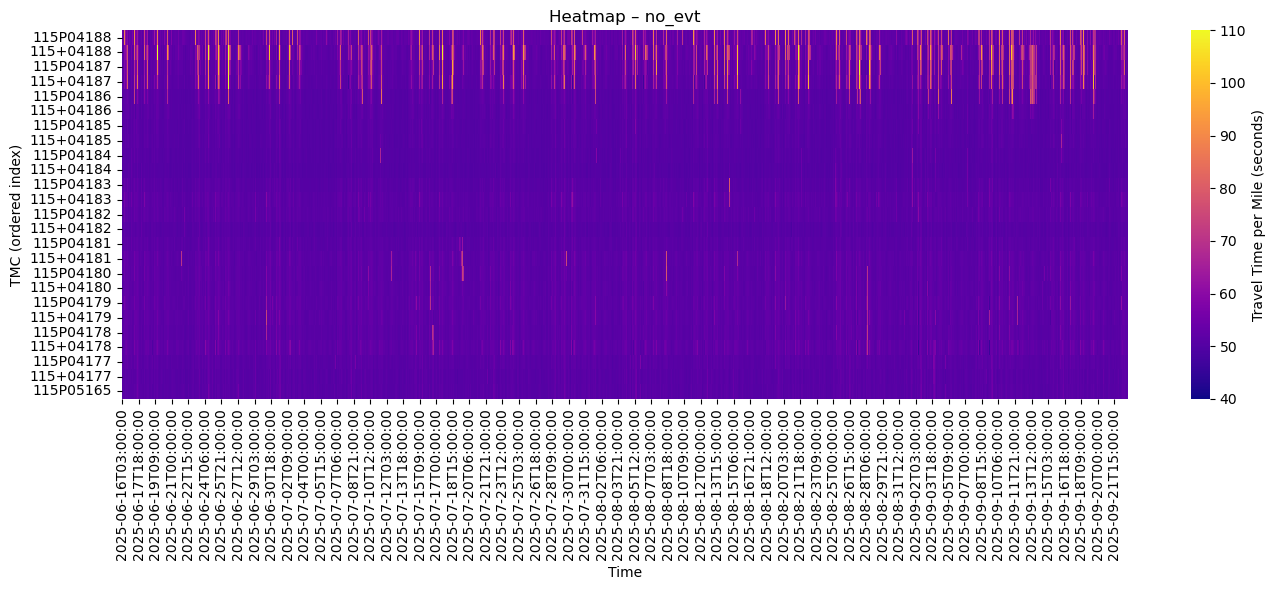

=== plnd_evt ===


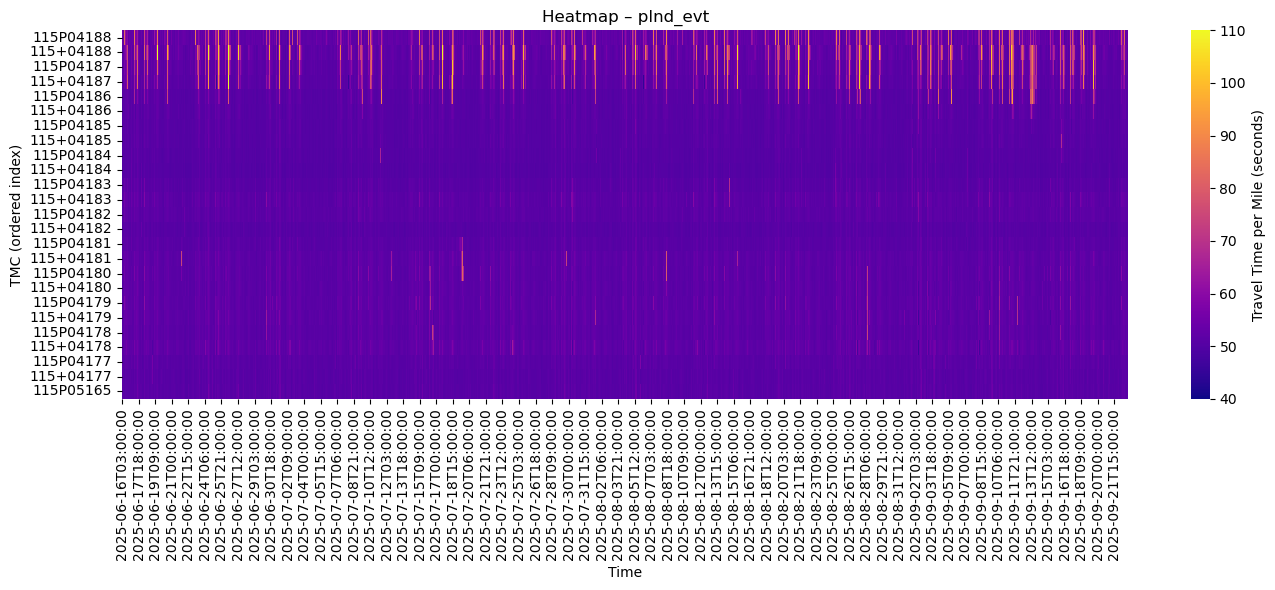

In [99]:
# compare prediction heatmaps (sklearn models)

# Chronological split
test_frac = 0.2
n_test = int(T * test_frac)

# Prepare storage for heatmaps
for name, model in models.items():

    print(f"=== {name} ===")

    # Build feature matrices for all TMCs and all timesteps
    feature_cols = model.regressor_.feature_names_in_.tolist()

    preds_full = []
    for tmc in tmc_order:
        grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
        X_tmc = grp[feature_cols]
        pred = model.predict(X_tmc)
        preds_full.append(pred)

    preds_full = np.array(preds_full)  # Now shape is [N, T]

    # Now reshape to [T, N]
    preds_2d = preds_full.T
    models[name].preds = preds_2d

    # Plot heatmap of predictions
    _=m.plot_heatmap_travel_time(
        preds=preds_2d,
        time_index=time_index,
        tmc_order=tmc_order,
        title=f"Heatmap – {name}",
        cmap='plasma',
        vmin=40, vmax=110
    )

In [17]:
# heatmap from gcn predictions
models['no_evt'].preds=m.plot_heatmap_travel_time(
        preds=models['no_evt'].preds,
        time_index=time_index[SEQ_LEN:],
        tmc_order=tmc_order,
        title="Heatmap – GCN-LSTM no_evt",
        cmap='plasma',
        vmin=40, vmax=110
    )
models['plnd_evt'].preds=m.plot_heatmap_travel_time(
        preds=models['plnd_evt'].preds,
        time_index=time_index[SEQ_LEN:],
        tmc_order=tmc_order,
        title="Heatmap – GCN-LSTM plnd_evt",
        cmap='plasma',
        vmin=40, vmax=110
    )

NameError: name 'SEQ_LEN' is not defined

(2374, 25)


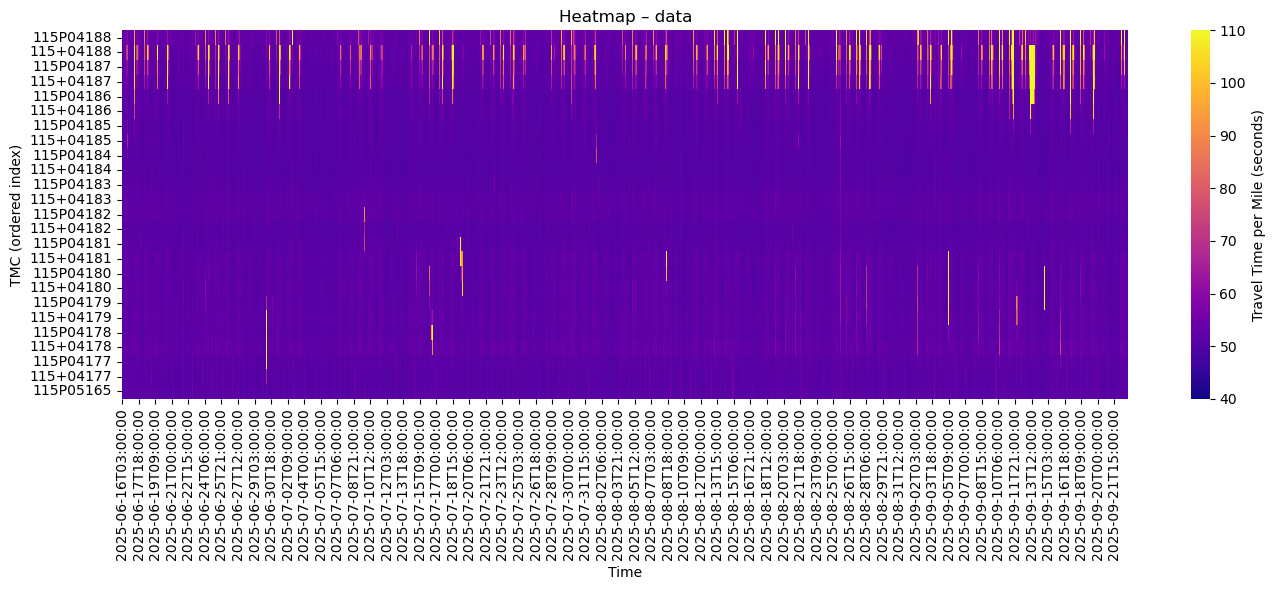

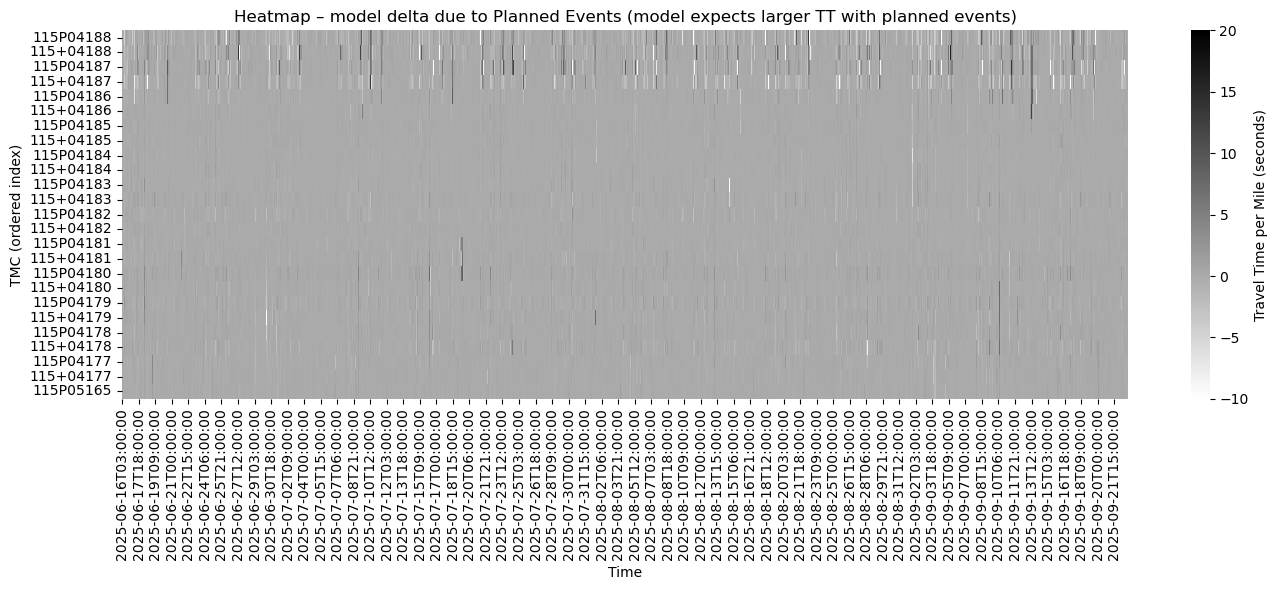

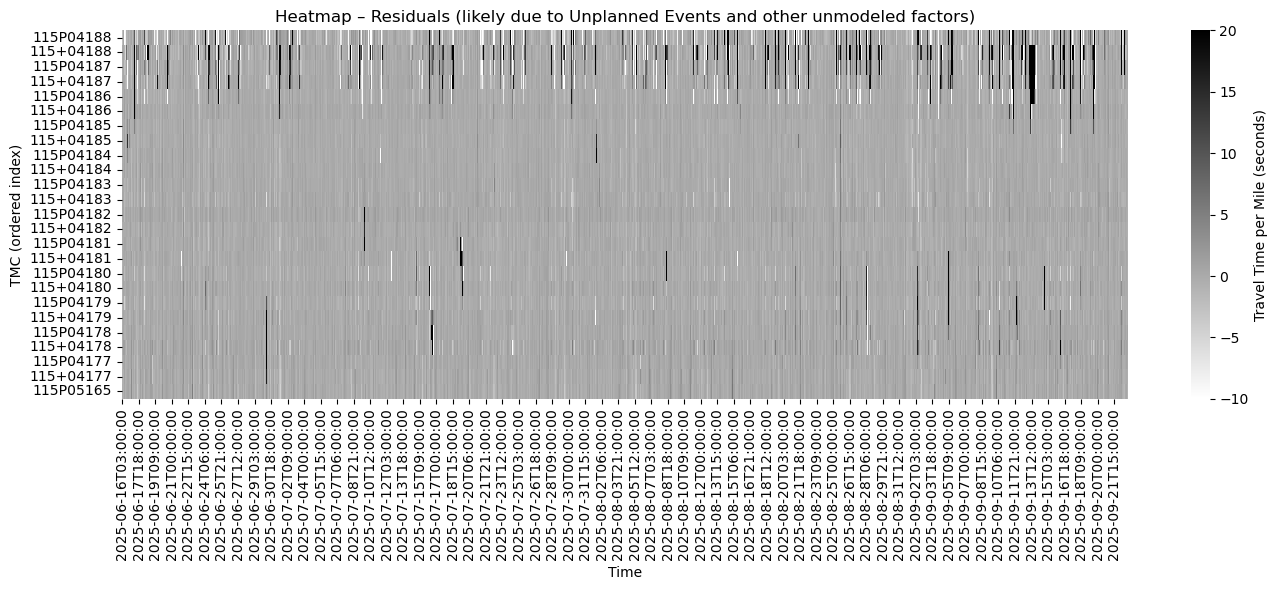

In [100]:
diff = models['plnd_evt'].preds - models['no_evt'].preds # positive: delay due to planned events  (2374, 25)
data_2d = X_full[TARGET_COL].unstack(level='tmc_code')[tmc_order]
print(data_2d.shape)
residuals = data_2d - models['plnd_evt'].preds  # (2374, 25)

data_2d = m.plot_heatmap_travel_time(
        preds=data_2d,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – data",
        cmap='plasma',
        vmin=40, vmax=110
    )

df_diff = m.plot_heatmap_travel_time(
        preds=diff,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – model delta due to Planned Events (model expects larger TT with planned events)",
        cmap='gray_r',
        vmin=-10, vmax=20
    )

df_residuals = m.plot_heatmap_travel_time(
        preds=residuals,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – Residuals (likely due to Unplanned Events and other unmodeled factors)",
        cmap='gray_r',
        vmin=-10, vmax=20
    )

In [25]:
df_residuals.describe()

,115N04188,115-04187,115N04187,115-04186,115N04186,115-04185,115N04185,115-04184,115N04184,115-04183,...,115-04180,115N04180,115-04179,115N04179,115-04178,115N04178,115-04177,115N04177,115-05165,115N05165
count,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,...,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000
mean,-0.212074,0.146310,-0.028684,-0.209018,-0.347379,-0.286332,-0.235831,-0.300544,-0.110079,-0.097249,...,-0.144359,0.174514,0.194222,-0.159614,-0.195550,-0.256550,-0.153403,-0.189342,-0.177636,-0.048785
std,4.709701,5.292912,11.354985,2.295477,1.269674,1.064947,1.079382,1.208465,1.306386,2.482491,...,2.357357,4.025812,3.400834,1.871801,1.429563,1.763856,1.470982,1.311643,5.401837,9.784777
min,-28.048934,-29.175527,-19.303177,-15.562922,-15.397864,-8.256200,-17.028430,-14.333697,-17.115372,-23.632761,...,-40.120605,-47.671828,-11.911599,-14.575651,-13.810504,-25.656096,-13.173617,-18.929654,-24.495886,-42.195039
25%,-0.887825,-0.516771,-0.726670,-0.496757,-0.591124,-0.617072,-0.551024,-0.610761,-0.400666,-0.472686,...,-0.485432,-0.446360,-0.418590,-0.577388,-0.621030,-0.612353,-0.515501,-0.452870,-0.715355,-0.759991
50%,-0.091046,0.153961,-0.159238,-0.140201,-0.206212,-0.197634,-0.184845,-0.232372,-0.077892,-0.071176,...,-0.145046,0.006886,0.051167,-0.133645,-0.136467,-0.169022,-0.049872,-0.050819,-0.170138,-0.221795
75%,0.614702,0.771445,0.292961,0.192582,0.160326,0.185302,0.188077,0.148178,0.264114,0.321016,...,0.158878,0.408036,0.524639,0.277970,0.293363,0.241345,0.388040,0.293045,0.318428,0.215076
max,129.867192,160.913056,374.495699,47.824670,19.827040,16.521167,18.939351,18.808890,36.448058,93.583629,...,57.596449,84.331870,104.656483,43.098695,27.738825,32.202237,39.237279,14.127550,148.260348,261.569751


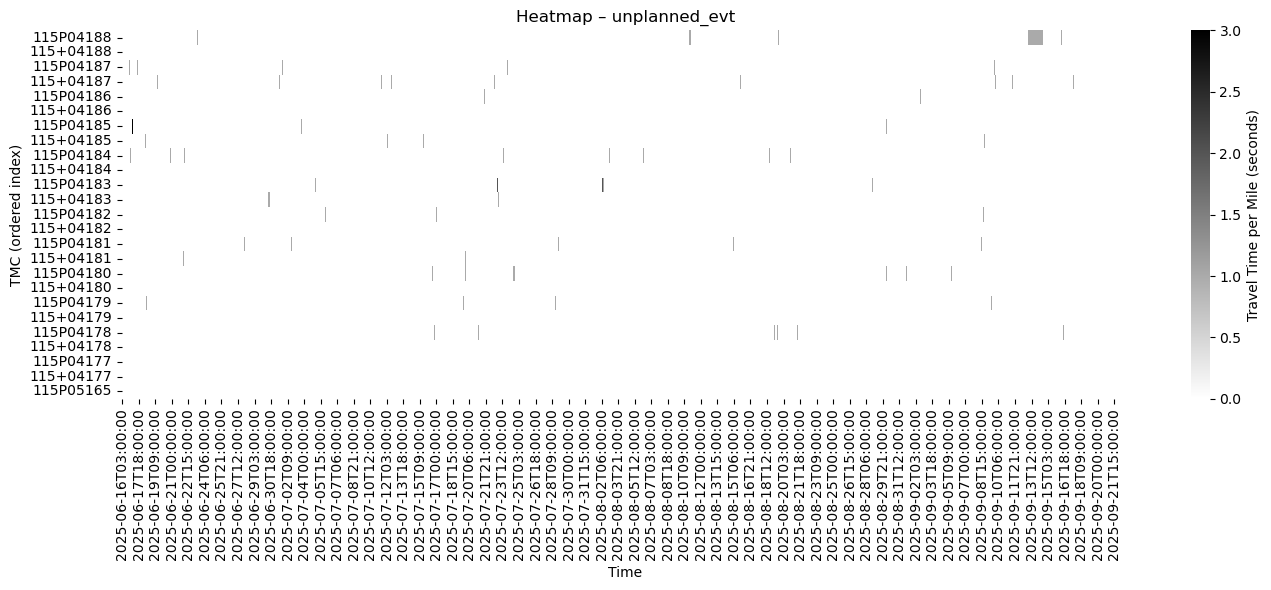

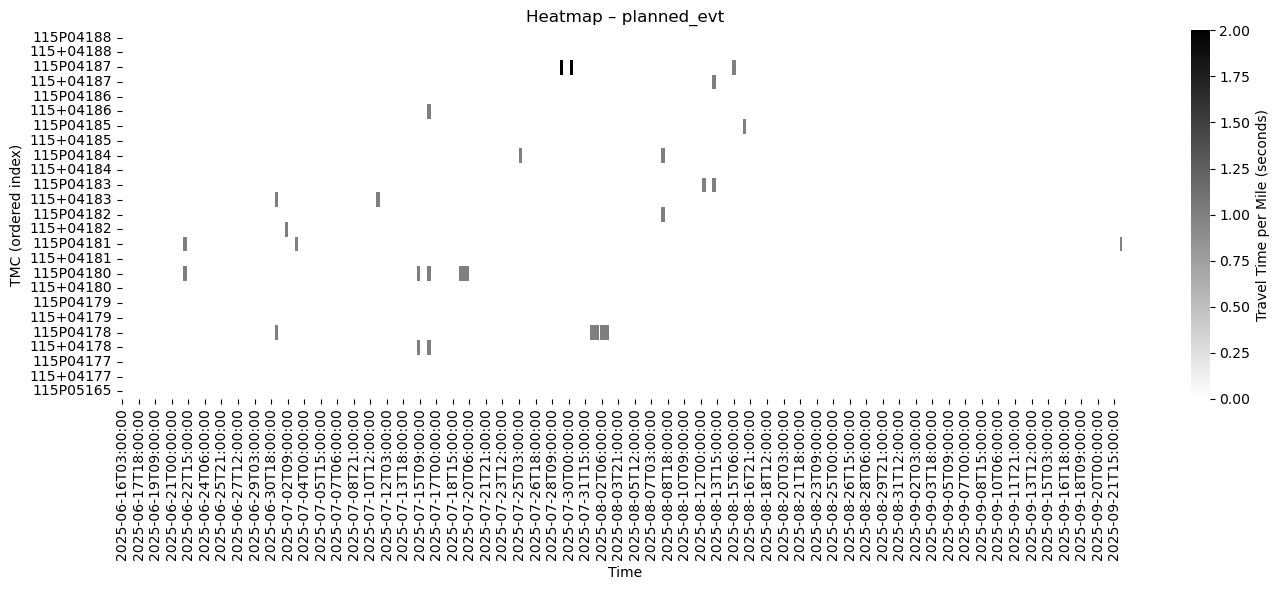

In [64]:
# get planned event 2d heatmap from the same direction in the same TMC order

df_unplnd_evt = m.plot_heatmap_travel_time(
        preds=X_full['evt_cat_unplanned'].unstack(level='tmc_code').fillna(0)[tmc_order],
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – unplanned_evt",
        cmap='gray_r',
        # vmin=-2, vmax=20
    )
df_plnd_evt = m.plot_heatmap_travel_time(
        preds=X_full['evt_cat_planned'].unstack(level='tmc_code').fillna(0)[tmc_order],
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – planned_evt",
        cmap='gray_r',
        # vmin=-2, vmax=20
    )

## Correlation analysis

In [178]:
df_long = (
    df_diff.stack()
    .rename("diff")
    .to_frame()
    .join(df_residuals.stack().rename("residuals"))
    .join(df_plnd_evt.stack().rename("plnd_evt"))
    .join(df_unplnd_evt.stack().rename("un_plnd_evt"))
    .reset_index()
    .rename(columns={"level_0": "time_bin", "level_1": "tmc"})
)

df_long['hour'] = df_long['time_bin'].dt.hour
df_long['dow'] = df_long['time_bin'].dt.dayofweek  # Monday=0, Sunday=6

# select the middle 95% quantile based on diff value
# df_long = df_long[df_long['diff'].between(df_long['diff'].quantile(0.001), df_long['diff'].quantile(0.999))]
df_long.head(3)

,time_bin,tmc,diff,residuals,plnd_evt,un_plnd_evt,hour,dow
0,2025-06-16 03:00:00+00:00,115P04188,-0.265156,-1.649956,0.0,0.0,3,0
1,2025-06-16 03:00:00+00:00,115+04188,-0.089157,0.336471,0.0,0.0,3,0
2,2025-06-16 03:00:00+00:00,115P04187,-0.079906,0.390587,0.0,0.0,3,0


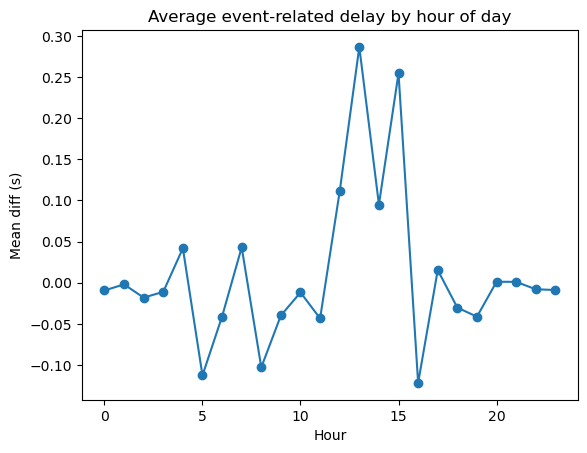

In [183]:
# Mean diff by hour (only during events)
event_mask = (df_long["plnd_evt"] == 1) | (df_long["un_plnd_evt"] == 1)
df_long.groupby("hour")["diff"].mean().plot(marker='o') # filter by event_mask if event data is reliable .loc[event_mask]
plt.title("Average event-related delay by hour of day")
plt.ylabel("Mean diff (s)")
plt.xlabel("Hour")
plt.show()

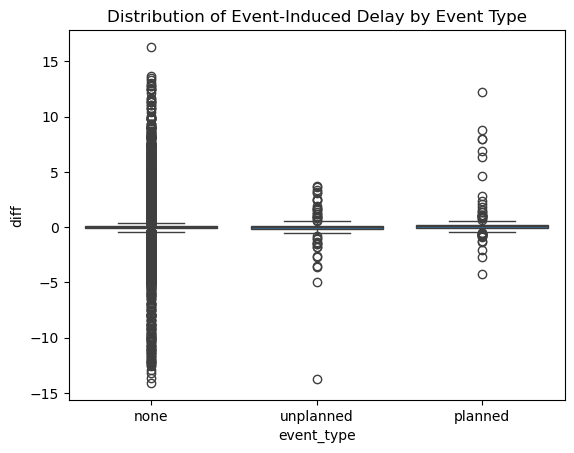

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
none,58911.0,0.009196,0.841721,-14.088684,-0.093042,0.006561,0.110338,16.308792
planned,237.0,0.311569,1.491953,-4.230045,-0.043297,0.083046,0.227123,12.214203
unplanned,202.0,-0.014772,1.370878,-13.743126,-0.135201,0.005852,0.144393,3.756462


In [186]:

df_long["event_type"] = np.select(
    [df_long["plnd_evt"] == 1, df_long["un_plnd_evt"] == 1],
    ["planned", "unplanned"],
    default="none"
)

sns.boxplot(x="event_type", y="diff", data=df_long)
plt.title("Distribution of Event-Induced Delay by Event Type")
plt.show()

df_long.groupby("event_type")["diff"].describe()

In [ ]:
# Spatial correlation
# Are segments (TMCs) that have more frequent events also the ones with higher mean travel time impact (diff)?
# total number of event time bins per TMC
df_long["event_flag"] = (df_long["plnd_evt"] == 1) #| (df_long["un_plnd_evt"] == 1)

agg_spatial = (
    df_long.groupby("tmc")
    .agg(
        mean_diff=("diff", "mean"),
        event_rate=("event_flag", "mean"),   # proportion of bins with event
        n_events=("event_flag", "sum")
    )
    .reset_index()
)
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(agg_spatial["mean_diff"], agg_spatial["event_rate"])
spearman_corr, _ = spearmanr(agg_spatial["mean_diff"], agg_spatial["event_rate"])
print(f"Spatial correlation (Pearson): {pearson_corr:.3f}")
print(f"Spatial correlation (Spearman): {spearman_corr:.3f}")
sns.scatterplot(
    x="event_rate", y="mean_diff", data=agg_spatial, alpha=0.6
)
plt.title("Spatial Correlation between Event Frequency and Mean Delay")
plt.xlabel("Event Rate (fraction of bins with event)")
plt.ylabel("Mean diff (s)")
plt.show()

Spatial correlation (Pearson): 0.209
Spatial correlation (Spearman): -0.026


Temporal correlation (zero lag): 0.012


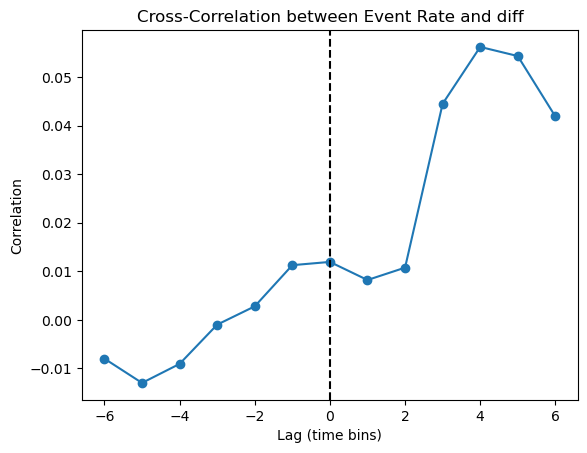

In [ ]:
# Temporal correlation between diff and events
# Do high diff periods coincide with event times, and is there a temporal lag (before or after event reports)?
agg_temporal = (
    df_long.groupby("time_bin")
    .agg(
        mean_diff=("diff", "mean"),
        event_rate=("event_flag", "mean")
    )
    .reset_index()
)
# compute correlation at zero lag
pearson_corr, _ = pearsonr(agg_temporal["mean_diff"], agg_temporal["event_rate"])
print(f"Temporal correlation (zero lag): {pearson_corr:.3f}")

# optional: cross-correlation for lags (±n bins)
lags = np.arange(-6, 7)
corr = [
    np.corrcoef(
        np.roll(agg_temporal["event_rate"], l), agg_temporal["mean_diff"]
    )[0, 1]
    for l in lags
]

plt.plot(lags, corr, marker="o")
plt.axvline(0, color="k", linestyle="--")
plt.title("Cross-Correlation between Event Rate and diff")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.show()

# correlation peaks at lag = 4hr, delay tend to continue after events.

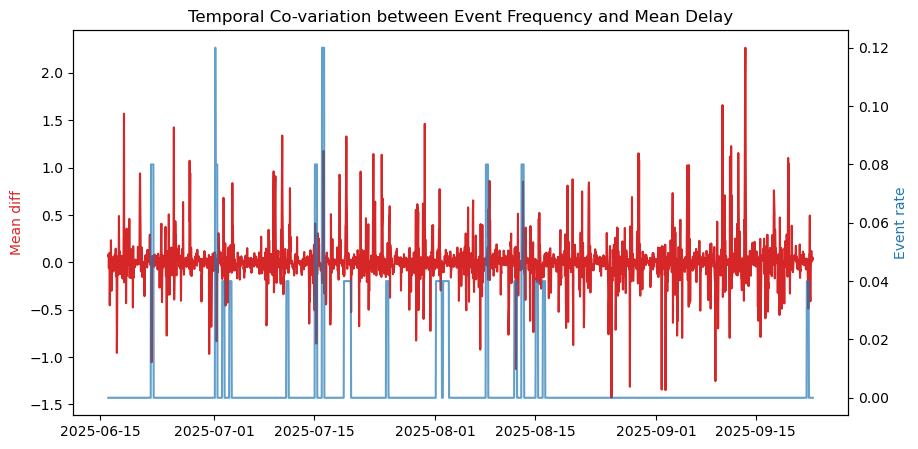

In [193]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(agg_temporal["time_bin"], agg_temporal["mean_diff"], color="tab:red", label="Mean diff")
ax1.set_ylabel("Mean diff", color="tab:red")

ax2 = ax1.twinx()
ax2.plot(agg_temporal["time_bin"], agg_temporal["event_rate"], color="tab:blue", alpha=0.7, label="Event rate")
ax2.set_ylabel("Event rate", color="tab:blue")

plt.title("Temporal Co-variation between Event Frequency and Mean Delay")
plt.show()

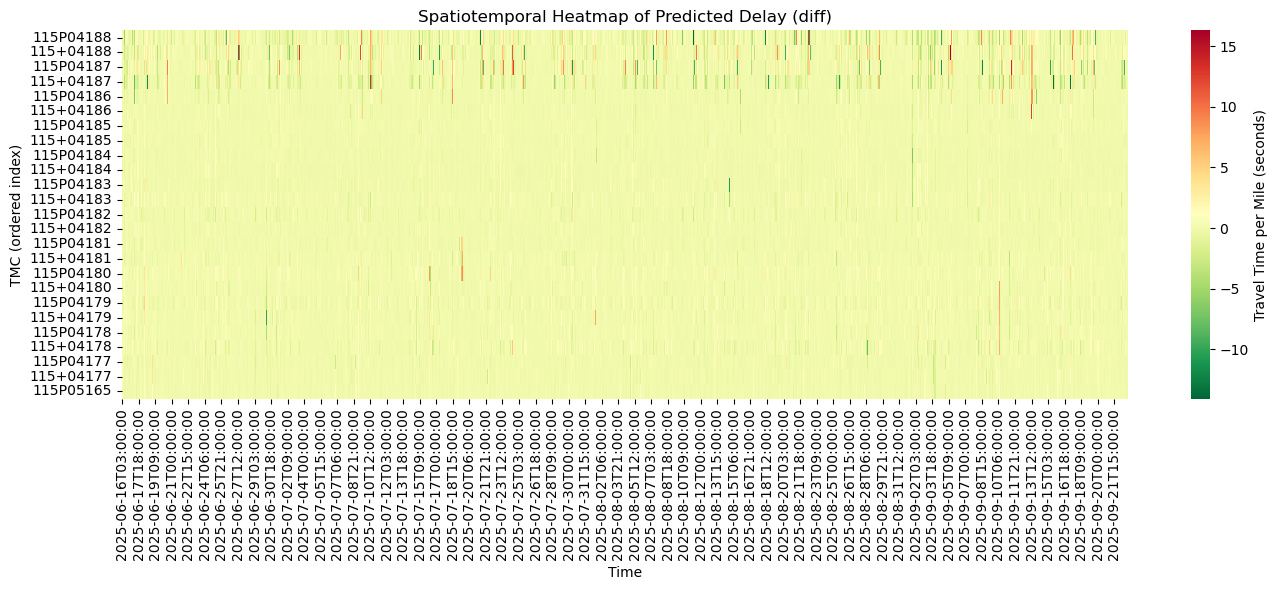

In [199]:
pivot_diff = df_long.pivot_table(
    index="tmc", columns="time_bin", values="diff", aggfunc="mean"
)
_=m.plot_heatmap_travel_time(
    preds=pivot_diff.loc[tmc_order].values.T, # reorder tmcs
    time_index=pivot_diff.columns,
    tmc_order=tmc_order,
    title="Spatiotemporal Heatmap of Predicted Delay (diff)",
    cmap="RdYlGn_r",
)

# plt.figure(figsize=(12,6))
# sns.heatmap(pivot_diff, cmap="RdYlGn_r", cbar_kws={'label': 'diff'})
# plt.title("Spatiotemporal Heatmap of Predicted Delay (diff)")
# plt.xlabel("Time")
# plt.ylabel("TMC")
# plt.show()

In [185]:
from scipy.stats import ttest_ind

planned = df_long.loc[df_long["plnd_evt"] == 1, "diff"]
unplanned = df_long.loc[df_long["plnd_evt"] != 1, "diff"]

t_stat, p_val = ttest_ind(planned, unplanned, equal_var=False)
print(f"T-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")

T-statistic = 3.12, p-value = 2.040e-03


In [187]:
# threshold for "high impact" events
high_delay = df_long.query("diff > diff.quantile(0.95)")

# count frequency of high-delay events per TMC
hotspots = high_delay.groupby("tmc").size().sort_values(ascending=False)
print(hotspots.head(10))
# join to geometry and plot top 5%
# top_hotspots = gdf_tmc.merge(hotspots.rename("count"), on="tmc")
# top_hotspots.plot(column="count", cmap="OrRd", legend=True)
# plt.title("High-Impact Event Hotspots")

tmc
115+04188    422
115P04188    410
115P04187    383
115P04180    206
115P04179    171
115+04187    148
115+04178    148
115P04186    113
115+04183    112
115+04179    101
dtype: int64


In [172]:
print("Overall correlation (df_diff vs planned_evt):", df_long["diff"].corr(df_long["plnd_evt"]))
print("Overall correlation (df_residual vs planned_evt):", df_long["residuals"].corr(df_long["plnd_evt"]))
print("Overall correlation (df_residual vs un_planned_evt):", df_long["residuals"].corr(df_long["un_plnd_evt"]))

Overall correlation (df_diff vs planned_evt): 0.02421764834444146
Overall correlation (df_residual vs planned_evt): -0.00022813946273202195
Overall correlation (df_residual vs un_planned_evt): 0.004275210154873227


In [173]:
df_long['diff'].describe()

count    59230.000000
mean         0.010866
std          0.695250
min         -8.951569
25%         -0.092659
50%          0.006739
75%          0.110600
max          8.293152
Name: diff, dtype: float64

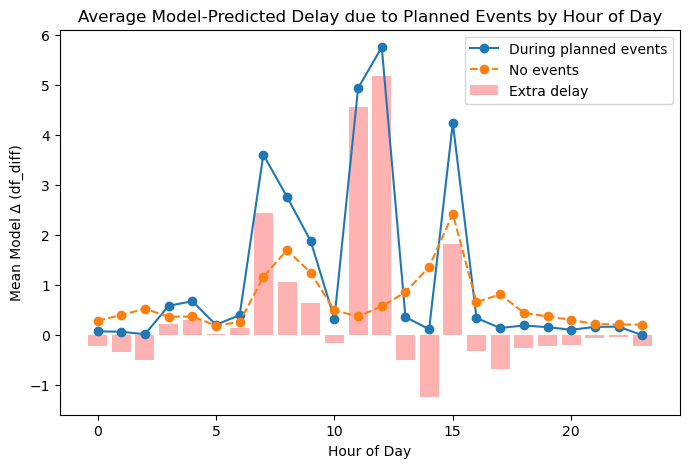

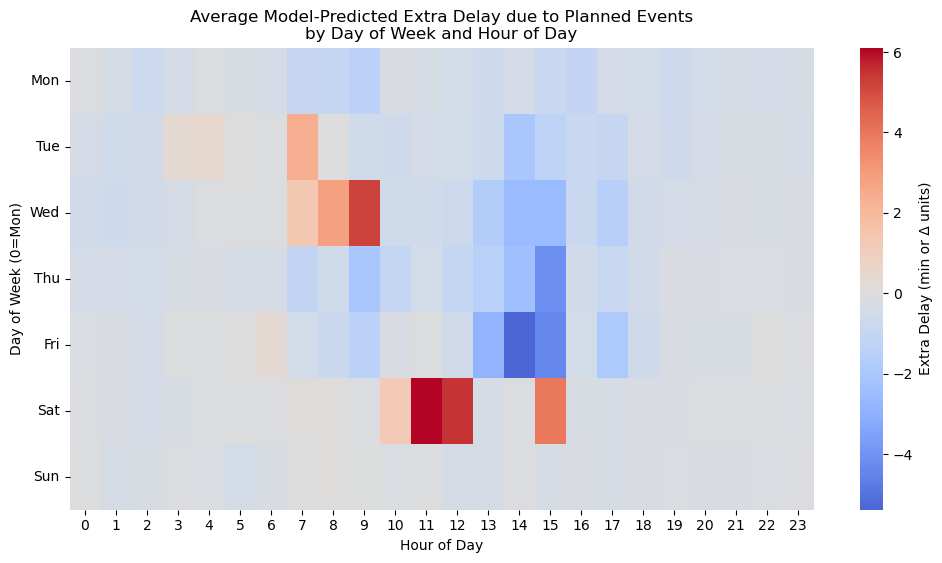

In [ ]:
# answer “the delay due to planned events at each hour of the day” 
from scipy.stats import gaussian_kde

def kde_map(x):
    if len(x) < 3 or np.allclose(x, x.iloc[0]):  # too few or identical
        return 0
    kde = gaussian_kde(x.dropna())
    xs = np.linspace(x.min(), x.max(), 200)
    ys = kde(xs)
    return xs[np.argmax(ys)]
def logmean(x, eps=1e-6):
    x = np.asarray(x.dropna())
    if len(x) == 0:
        return np.nan
    signs = np.sign(x)
    logvals = np.log(np.abs(x) + eps)
    mean_log = np.mean(logvals)
    # use the dominant sign (most common or mean sign)
    sign = np.sign(np.mean(signs))
    return sign * np.exp(mean_log)

def weighted_mean(x, w):
    x, w = np.asarray(x), np.asarray(w)
    mask = ~np.isnan(x) & ~np.isnan(w)
    if not np.any(mask):
        return np.nan
    return np.average(x[mask], weights=w[mask])

# Step 3: group by hour and event condition
grouped = (
    df_long.groupby(['hour', (df_long['plnd_evt'] > 0)])['diff']
    .quantile(0.95)
    .unstack(fill_value=0)
    .rename(columns={False: 'no_event', True: 'with_event'})
)
grouped_2d = (
    df_long.groupby(['dow', 'hour', (df_long['plnd_evt'] > 0)])['diff']
    .quantile(0.95)
    .unstack(fill_value=0)
    .rename(columns={False: 'no_event', True: 'with_event'})
)
# Step 4: compute difference
grouped['extra_delay'] = grouped['with_event'] - grouped['no_event']
grouped_2d['extra_delay'] = grouped_2d['with_event'] - grouped_2d['no_event']

plt.figure(figsize=(8,5))
plt.plot(grouped.index, grouped['with_event'], label='During planned events', marker='o')
plt.plot(grouped.index, grouped['no_event'], label='No events', marker='o', linestyle='--')
plt.bar(grouped.index, grouped['extra_delay'], alpha=0.3, label='Extra delay', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Model Δ (df_diff)')
plt.title('Average Model-Predicted Delay due to Planned Events by Hour of Day')
plt.legend()
plt.show()

# Pivot to 2D matrix for plotting
heatmap_data = grouped_2d['extra_delay'].unstack(level='hour')

# Order weekdays (optional: 0=Mon to 6=Sun)
plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Extra Delay (min or Δ units)'}
)
plt.title('Average Model-Predicted Extra Delay due to Planned Events\nby Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon)')
plt.yticks(ticks=np.arange(0.5,7.5,1), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.show()

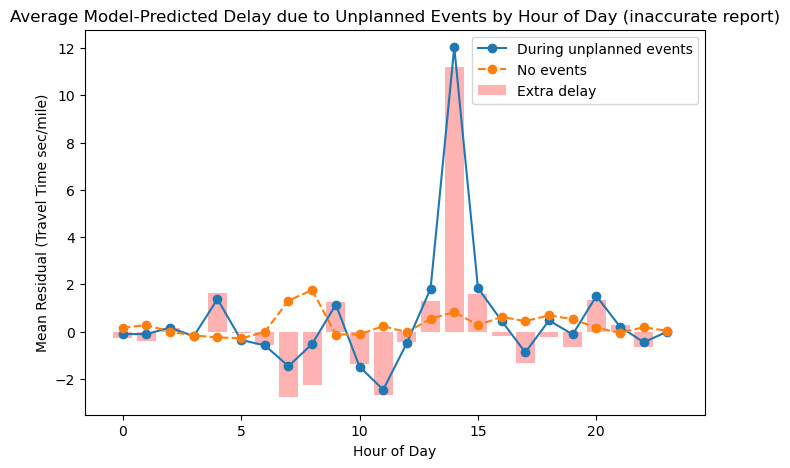

In [146]:
# answer “the delay due to unplanned events and other unmodeled factors at each hour of the day” 

# Step 2: extract hour-of-day
df_long['hour'] = df_long['time_bin'].dt.hour

# Step 3: group by hour and event condition
grouped = (
    df_long.groupby(['hour', (df_long['un_plnd_evt'] > 0)])
    ['residuals']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={False: 'no_event', True: 'with_event'})
)

# Step 4: compute difference
grouped['extra_delay'] = grouped['with_event'] - grouped['no_event']

plt.figure(figsize=(8,5))
plt.plot(grouped.index, grouped['with_event'], label='During unplanned events', marker='o')
plt.plot(grouped.index, grouped['no_event'], label='No events', marker='o', linestyle='--')
plt.bar(grouped.index, grouped['extra_delay'], alpha=0.3, label='Extra delay', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Residual (Travel Time sec/mile)')
plt.title('Average Model-Predicted Delay due to Unplanned Events by Hour of Day (inaccurate report)')
plt.legend()
plt.show()

In [48]:
grouped

un_plnd_evt,no_event,with_event,extra_delay
hour,,,
0,0.762537,0.446177,-0.316361
1,0.853213,0.848244,-0.004969
2,0.724495,1.464997,0.740502
3,0.394043,0.161540,-0.232503
4,0.350734,3.693588,3.342853
5,0.549113,0.571548,0.022435
6,-0.205150,-0.147919,0.057231
7,1.023540,-0.032675,-1.056215
8,1.577016,-0.821386,-2.398402


## 2D correlation
	•	df_plnd_evt (planned event intensity  →  input)
	•	df_unplnd_evt (unplanned events  →  input)
	•	df_diff (model delta →  response),

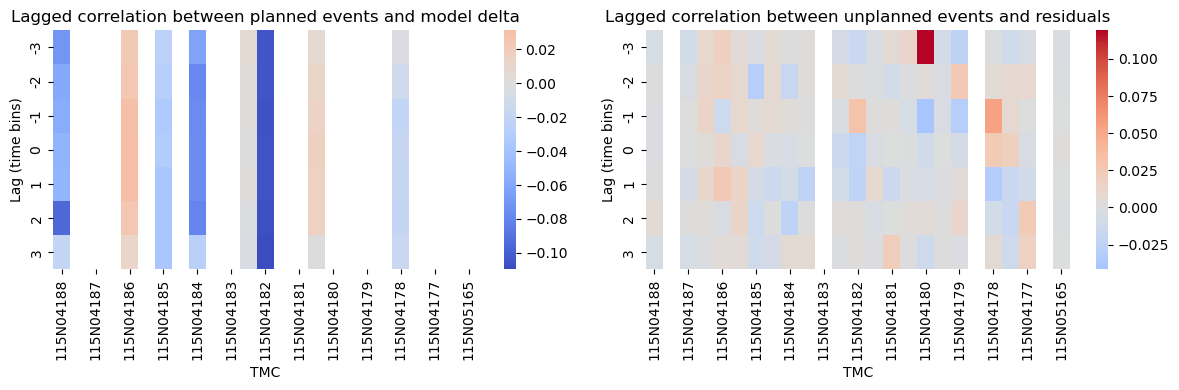

In [26]:
lags = range(-3, 4)  # e.g., ±1 hours
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
corrs = pd.DataFrame(index=df_plnd_evt.columns, columns=lags)
for lag in lags:
    shifted = df_plnd_evt.shift(lag)
    corrs[lag] = shifted.corrwith(df_diff)

sns.heatmap(corrs.T, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_xlabel("TMC")
axes[0].set_ylabel("Lag (time bins)")
axes[0].set_title("Lagged correlation between planned events and model delta")

corrs = pd.DataFrame(index=df_unplnd_evt.columns, columns=lags)
for lag in lags:
    shifted = df_unplnd_evt.shift(lag)
    corrs[lag] = shifted.corrwith(df_residuals)

sns.heatmap(corrs.T, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_xlabel("TMC")
axes[1].set_ylabel("Lag (time bins)")
axes[1].set_title("Lagged correlation between unplanned events and residuals")

plt.tight_layout()
plt.show()